In [1]:
import torch
import matplotlib.pyplot as plt
import math

def closest_factors(num): 
    sq = int(math.sqrt(num)) + 1
    for i in range(sq, 1, -1): 
        if num % i == 0: 
            return i, num // i
    return 1, num

def plot_image_grid(tensor, title="Image Grid"):   
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")
    if tensor.ndim != 4 or tensor.shape[1] != 3:
        raise ValueError("Input tensor must have shape (N, 3, H, W) for RGB images.")

    f1, f2 = closest_factors(tensor.shape[0])

    fig, axes = plt.subplots(f1, f2, figsize=(f2 * 2, f1 * 2))
    fig.suptitle(title)

    axes = axes.flatten() if tensor.shape[0] > 1 else [axes]
    for i, ax in enumerate(axes):
        if i < tensor.shape[0]:
            img = tensor[i].detach().cpu().permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis("off")
        else:
            ax.remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_tensor_matrix(tensor, title="Tensor Matrix", cmap="viridis"):
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")
    if tensor.dim() != 2:
        raise ValueError("Only 2D tensors can be plotted as matrices.")
    plt.imshow(tensor.detach().cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

    

In [2]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.1307,), (0.3081,))  
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [3]:
mnist_tensor = []
mnist_labels = []

for images, labels in train_loader:
    mnist_tensor.append(images) 
    mnist_labels.append(labels)  

for images, labels in test_loader: 
    mnist_tensor.append(images) 
    mnist_labels.append(labels)  

mnist_tensor = torch.cat(mnist_tensor, dim=0)
mnist_labels = torch.cat(mnist_labels, dim=0)

print(mnist_tensor.shape)
print(mnist_labels.shape)

# torch.save(mnist_tensor, "mnist_tensor.pth")
torch.save(mnist_labels, "data/mnist_labels.pth")

torch.Size([70000, 1, 28, 28])
torch.Size([70000])


In [27]:
from torch import nn 

class SimpleLinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        B, C, W, H = x.shape
        x_flat = x.reshape(B, -1)
        y_flat = self.linear(x_flat)
        W = int((y_flat.shape[1]/C)**0.5)
        return y_flat.reshape(B, C, W, W)

In [10]:
class ZeroMeanUnitStdLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.reduction = 'mean'

    def forward(self, x):
        mean = x.mean(dim=0)
        std = x.std(dim=0, unbiased=False)
        mean_loss = (mean ** 2).mean()
        std_loss = ((std - 1) ** 2).mean()
        loss = mean_loss + std_loss
        return loss

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

mnist_tensor3 = torch.load("mnist_tensor3.pth")
print(mnist_tensor3.shape)
dataset = TensorDataset(mnist_tensor3[::5])
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

torch.Size([70000, 3, 28, 28])


In [ ]:
from models import Encoder, Decoder, count_parameters, VGGLoss
import torch.nn as nn
from tqdm import tqdm

device = torch.device('cuda')

# enc = Encoder(3, 3, 64, 2).to(device)
# dec = Decoder(3, 3, 64, 2).to(device)

# enc = SimpleLinearModel(3*28*28, 3*14*14).cuda()
# dec = SimpleLinearModel(3*14*14, 3*28*28).cuda()


enc = torch.load("models/enc.pth", weights_only=False)
dec = torch.load("models/dec.pth", weights_only=False)

cri0 = ZeroMeanUnitStdLoss()
cri1 = VGGLoss(dev=device)
cri2 = nn.MSELoss()

lr = 2e-4
optimizer1 = torch.optim.AdamW(enc.parameters(), lr=lr)
optimizer2 = torch.optim.AdamW(dec.parameters(), lr=lr)

num_epochs = 3 

for epoch in range(num_epochs):
    total_loss = 0.0 

    for tens, in tqdm(dataloader): 
        x = tens.to(device)
        z = enc(x)
        y = dec(z)

        loss0 = cri0(z)
        loss1 = cri1(y,x)
        loss2 = cri2(y,x)


        loss = 0.1*loss1 + 0.9*loss2 + loss0
        total_loss += loss.item()

        optimizer1.zero_grad(), optimizer2.zero_grad()
        loss.backward()
        optimizer1.step(), optimizer2.step()

    
    print(f"Epoch {epoch} Loss: {total_loss}")


c:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 36%|███▋      | 20/55 [00:02<00:04,  7.19it/s]


KeyboardInterrupt: 

torch.Size([16, 3, 28, 28])
torch.Size([16, 3, 14, 14])
torch.Size([16, 3, 28, 28])
torch.Size([16, 3, 14, 14])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58417743..3.0007799].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.615827..3.0167427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57353747..2.9846778].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5283145..3.028034].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5964088..3.0015821].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60460037..2.9612715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.50134

tensor([ 0.0413,  0.0007,  0.1112,  0.0109, -0.0105,  0.0226, -0.0485, -0.0230,
        -0.0148,  0.0046, -0.0513,  0.0563,  0.0110, -0.0235, -0.0082,  0.0144],
       device='cuda:0', grad_fn=<MeanBackward1>)
tensor([1.0652, 0.9241, 1.0649, 0.8477, 1.0078, 1.0727, 0.7146, 0.9135, 0.6596,
        1.0503, 0.8805, 1.2714, 0.9267, 0.9933, 0.6129, 1.0440],
       device='cuda:0', grad_fn=<StdBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58432007..2.968307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.501076..2.9714437].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5778973..3.0141897].


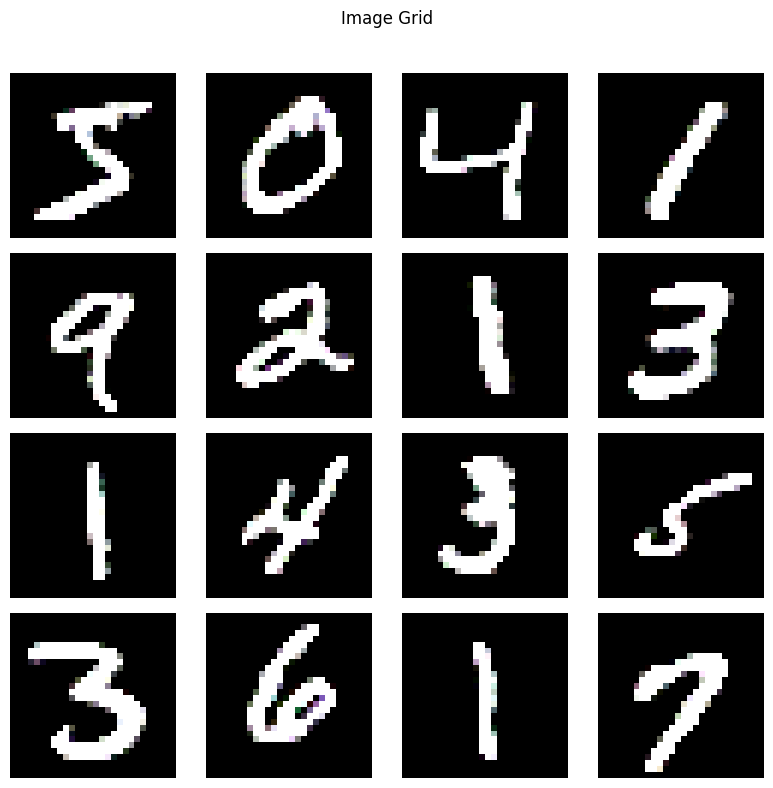

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

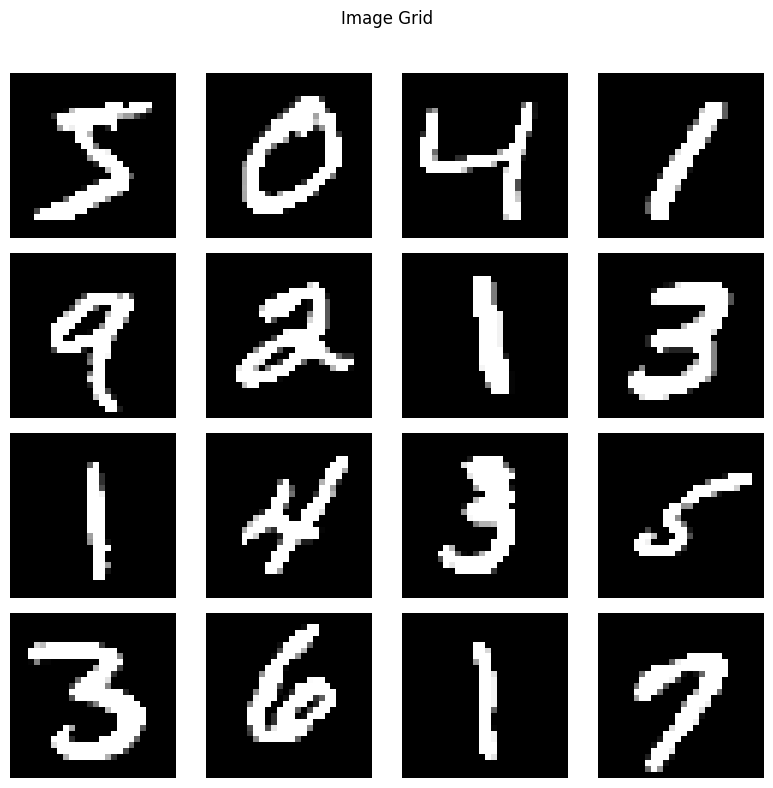

In [4]:
import torch 

mnist_tensor3 = torch.load("data/mnist_tensor3.pth")


bs = 16
X = mnist_tensor3[:bs].cuda()
print(X.shape)

enc = torch.load("model_collection/enczmuv.pth", weights_only=False)
dec = torch.load("model_collection/deczmuv.pth", weights_only=False)
enc.eval(), dec.eval()

# with torch.no_grad():
#     total_loss = 0.0 

#     for tens, in tqdm(dataloader): 
#         x = tens.to(device)
#         z = enc(x)
#         y = dec(z)

#         loss0 = cri0(z)
#         loss1 = cri1(y,x)
#         loss2 = cri2(y,x)

#         loss = 0.1*loss1 + 0.9*loss2 + loss0
#         total_loss += loss.item()
#     print(f"Total Loss: {total_loss}")


z = enc(X)
print(z.shape)
Y = dec(z)

print(Y.shape)
print(z.shape)
print(z.mean(dim=(1, 2, 3)))
print(z.std(dim=(1, 2, 3)))
plot_image_grid(Y)
plot_image_grid(X)
